# TensorFlow vs NumPy BipolarImageProcessor

This notebook compares the legacy NumPy/SciPy pipeline with the new TensorFlow implementation and checks numerical agreement.


In [1]:
import os
os.environ["TF_ENABLE_ONEDNN_OPTS"] = "0"

import sys
import types
import importlib.util
from pathlib import Path

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

np.random.seed(0)
tf.random.set_seed(0)


In [2]:
# Load chromopho modules without importing chromopho/__init__.py (torch dependency)
def load_module(name, path):
    spec = importlib.util.spec_from_file_location(name, path)
    module = importlib.util.module_from_spec(spec)
    sys.modules[name] = module
    spec.loader.exec_module(module)
    return module

repo_root = Path.cwd()
pkg_root = repo_root / "chromopho"
if not pkg_root.exists():
    raise FileNotFoundError(f"Expected chromopho package at {pkg_root}")

if "chromopho" not in sys.modules:
    pkg = types.ModuleType("chromopho")
    pkg.__path__ = [str(pkg_root)]
    sys.modules["chromopho"] = pkg

utils = load_module("chromopho.utils", pkg_root / "utils.py")
plot = load_module("chromopho.plot", pkg_root / "plot.py")
mosaic_mod = load_module("chromopho.mosaic", pkg_root / "mosaic.py")
bipolar_mod = load_module("chromopho.bipolar_image", pkg_root / "bipolar_image.py")
bipolar_tf_mod = load_module("chromopho.bipolar_image_tf", pkg_root / "bipolar_image_tf.py")

BipolarSubtype = mosaic_mod.BipolarSubtype
BipolarMosaic = mosaic_mod.BipolarMosaic
BipolarImageProcessor = bipolar_mod.BipolarImageProcessor
BipolarImageProcessorTF = bipolar_tf_mod.BipolarImageProcessorTF


## Build a test mosaic and image
We keep the mosaic small for quick comparison while still exercising multiple subtypes.


In [3]:
def build_mosaic(num_cells=900):
    s_rf_params = {"center_sigma": 8.0, "surround_sigma": 25.0, "alpha_center": 1, "alpha_surround": 0.25}
    s_off = BipolarSubtype(name="s_off", ratio=2.5/100, rf_size=15, color_filter_params={"center": "-s", "surround": "+lm"}, rf_params=s_rf_params)
    s_on  = BipolarSubtype(name="s_on",  ratio=2.5/100, rf_size=15, color_filter_params={"center": "+s", "surround": "-lm"}, rf_params=s_rf_params)

    lm_rf_params = {"center_sigma": 3.0, "surround_sigma": 10.0, "alpha_center": 1, "alpha_surround": 0.65}
    m_on  = BipolarSubtype(name="m_on",  ratio=18/100, rf_size=6, color_filter_params={"center": "+m", "surround": "-l"}, rf_params=lm_rf_params)
    m_off = BipolarSubtype(name="m_off", ratio=18/100, rf_size=6, color_filter_params={"center": "-m", "surround": "+l"}, rf_params=lm_rf_params)

    l_on  = BipolarSubtype(name="l_on",  ratio=18/100, rf_size=6, color_filter_params={"center": "+l", "surround": "-m"}, rf_params=lm_rf_params)
    l_off = BipolarSubtype(name="l_off", ratio=19/100, rf_size=6, color_filter_params={"center": "-l", "surround": "+m"}, rf_params=lm_rf_params)

    dif_on  = BipolarSubtype(name="dif_on",  ratio=10/100, rf_size=8, color_filter_params={"center": "+lm", "surround": "-lm"})
    dif_off = BipolarSubtype(name="dif_off", ratio=10/100, rf_size=8, color_filter_params={"center": "-lm", "surround": "+lm"})

    return BipolarMosaic(num_cells, shape="circle", subtypes=[m_off, m_on, l_off, l_on, s_off, s_on, dif_on, dif_off], density_swap=False)

mosaic = build_mosaic()


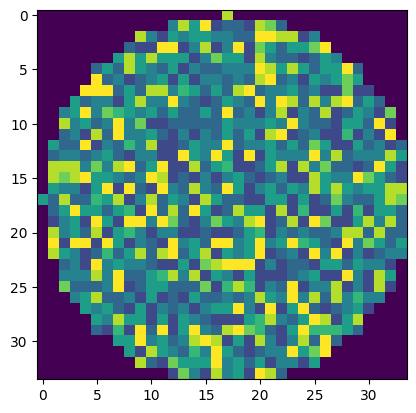

In [4]:
plt.imshow(mosaic.grid)

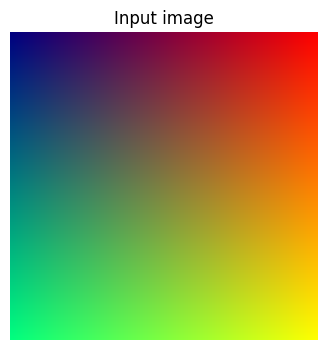

In [5]:
h, w = 128, 128
x = np.linspace(0, 1, w)
y = np.linspace(0, 1, h)
xx, yy = np.meshgrid(x, y)
img = np.stack([xx, yy, 0.5 * (1 - xx)], axis=-1).astype(np.float32)

plt.figure(figsize=(4, 4))
plt.imshow(img)
plt.title("Input image")
plt.axis("off")
plt.show()


## Run both processors and compare outputs


In [6]:
bip_np = BipolarImageProcessor(mosaic, img, save_flat=True, amacrine_sigma_blur=None)
bip_tf = BipolarImageProcessorTF(mosaic, img, save_flat=True, amacrine_sigma_blur=None)

out_np = bip_np.grid_outputs
out_tf = bip_tf.grid_outputs.numpy()
diff = out_tf - out_np

max_diff = np.max(np.abs(diff))
print("max abs diff:", max_diff)
print("allclose (atol=1e-7):", np.allclose(out_np, out_tf, atol=1e-7, rtol=0))


max abs diff: 2.306180552080761e-08
allclose (atol=1e-7): True


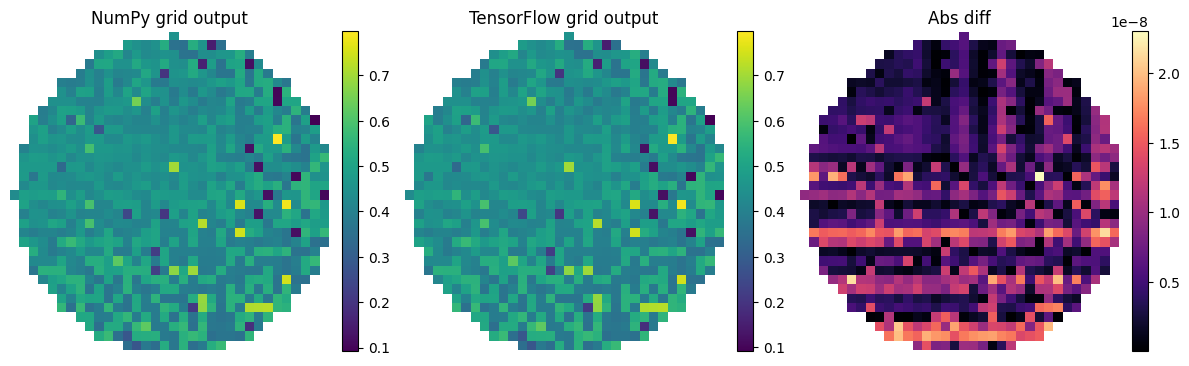

In [7]:
valid_mask = out_np != -1
plot_np = out_np.copy()
plot_tf = out_tf.copy()
plot_diff = np.abs(diff)
plot_np[~valid_mask] = np.nan
plot_tf[~valid_mask] = np.nan
plot_diff[~valid_mask] = np.nan

fig, axes = plt.subplots(1, 3, figsize=(12, 4))
im0 = axes[0].imshow(plot_np, cmap="viridis")
axes[0].set_title("NumPy grid output")
axes[0].axis("off")
plt.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04)

im1 = axes[1].imshow(plot_tf, cmap="viridis")
axes[1].set_title("TensorFlow grid output")
axes[1].axis("off")
plt.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)

im2 = axes[2].imshow(plot_diff, cmap="magma")
axes[2].set_title("Abs diff")
axes[2].axis("off")
plt.colorbar(im2, ax=axes[2], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()


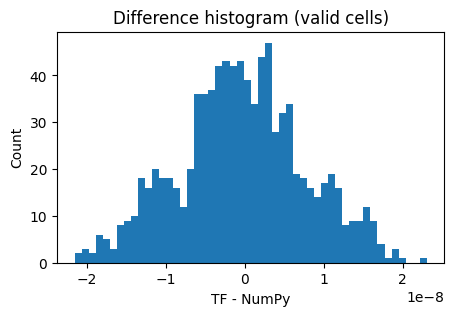

In [8]:
plt.figure(figsize=(5, 3))
plt.hist(diff[valid_mask].ravel(), bins=50)
plt.title("Difference histogram (valid cells)")
plt.xlabel("TF - NumPy")
plt.ylabel("Count")
plt.show()


## Batch validation across images, mosaics, and settings
This section runs multiple combinations and reports max and mean absolute differences.


In [9]:
def build_mosaic_variant(num_cells=900, shape="circle", center_sigma_lm=3.0, surround_sigma_lm=10.0, alpha_surround_lm=0.65, center_sigma_s=8.0, surround_sigma_s=25.0):
    s_rf_params = {"center_sigma": center_sigma_s, "surround_sigma": surround_sigma_s, "alpha_center": 1, "alpha_surround": 0.25}
    s_off = BipolarSubtype(name="s_off", ratio=2.5/100, rf_size=15, color_filter_params={"center": "-s", "surround": "+lm"}, rf_params=s_rf_params)
    s_on  = BipolarSubtype(name="s_on",  ratio=2.5/100, rf_size=15, color_filter_params={"center": "+s", "surround": "-lm"}, rf_params=s_rf_params)

    lm_rf_params = {"center_sigma": center_sigma_lm, "surround_sigma": surround_sigma_lm, "alpha_center": 1, "alpha_surround": alpha_surround_lm}
    m_on  = BipolarSubtype(name="m_on",  ratio=18/100, rf_size=6, color_filter_params={"center": "+m", "surround": "-l"}, rf_params=lm_rf_params)
    m_off = BipolarSubtype(name="m_off", ratio=18/100, rf_size=6, color_filter_params={"center": "-m", "surround": "+l"}, rf_params=lm_rf_params)

    l_on  = BipolarSubtype(name="l_on",  ratio=18/100, rf_size=6, color_filter_params={"center": "+l", "surround": "-m"}, rf_params=lm_rf_params)
    l_off = BipolarSubtype(name="l_off", ratio=19/100, rf_size=6, color_filter_params={"center": "-l", "surround": "+m"}, rf_params=lm_rf_params)

    dif_on  = BipolarSubtype(name="dif_on",  ratio=10/100, rf_size=8, color_filter_params={"center": "+lm", "surround": "-lm"})
    dif_off = BipolarSubtype(name="dif_off", ratio=10/100, rf_size=8, color_filter_params={"center": "-lm", "surround": "+lm"})

    return BipolarMosaic(num_cells, shape=shape, subtypes=[m_off, m_on, l_off, l_on, s_off, s_on, dif_on, dif_off], density_swap=False)

def make_images(h=128, w=128):
    x = np.linspace(0, 1, w)
    y = np.linspace(0, 1, h)
    xx, yy = np.meshgrid(x, y)

    gradient = np.stack([xx, yy, 0.5 * (1 - xx)], axis=-1).astype(np.float32)

    checker = ((np.floor(xx * 8) + np.floor(yy * 8)) % 2).astype(np.float32)
    checker = np.stack([checker, checker, checker], axis=-1)

    radial_base = np.sqrt((xx - 0.5) ** 2 + (yy - 0.5) ** 2)
    radial_base = np.clip(1 - radial_base * 2.0, 0, 1).astype(np.float32)
    radial = np.stack([radial_base, radial_base ** 0.5, radial_base ** 2], axis=-1)

    rng = np.random.default_rng(123)
    noise = rng.uniform(0, 1, size=(h, w, 3)).astype(np.float32)

    alpha = (radial_base > 0.2).astype(np.float32)
    rgba = np.concatenate([gradient, alpha[..., None]], axis=-1)

    circle = (((xx - 0.5) ** 2 + (yy - 0.5) ** 2) <= (0.25 ** 2)).astype(np.float32)
    circle = np.stack([circle, circle, circle], axis=-1)

    square = ((np.abs(xx - 0.5) <= 0.2) & (np.abs(yy - 0.5) <= 0.2)).astype(np.float32)
    square = np.stack([square, square, square], axis=-1)

    y0, y1 = 0.25, 0.75
    half_width = (yy - y0)
    triangle = (yy >= y0) & (yy <= y1) & (xx >= 0.5 - half_width) & (xx <= 0.5 + half_width)
    triangle = triangle.astype(np.float32)
    triangle = np.stack([triangle, triangle, triangle], axis=-1)

    return [
        ("gradient", gradient),
        ("checker", checker),
        ("radial", radial),
        ("noise", noise),
        ("rgba", rgba),
        ("circle", circle),
        ("square", square),
        ("triangle", triangle),
    ]

images = make_images()
mosaics = [
    ("circle_small", build_mosaic_variant(num_cells=400, shape="circle")),
    ("circle_medium", build_mosaic_variant(num_cells=900, shape="circle", center_sigma_lm=4.0, surround_sigma_lm=12.0, alpha_surround_lm=0.5)),
    ("rect_small", build_mosaic_variant(num_cells=625, shape="rectangle")),
]

# settings options:
# - base: raw bipolar outputs (no blur, no stimulation)
# - blur_1p5: apply amacrine-style Gaussian blur on the grid outputs
# - stim: bypass image filtering and inject a stimulation mosaic
settings = [
    {"name": "base", "amacrine_sigma_blur": None, "stimulation": False},
    {"name": "blur_1p5", "amacrine_sigma_blur": 1.5, "stimulation": False},
    {"name": "stim", "amacrine_sigma_blur": None, "stimulation": True},
]


In [10]:
def build_stim_mosaic(grid, seed=7):
    rng = np.random.default_rng(seed)
    stim = rng.uniform(0, 1, size=grid.shape).astype(np.float32)
    stim[grid == -1] = 0.0
    return stim

def build_np_grid_from_avg_map(bip, blur_sigma=None):
    h, w = bip.mosaic.grid.shape
    grid = np.full((h, w), -1.0, dtype=float)
    if bip.avg_colors_cell_map:
        keys = np.array(list(bip.avg_colors_cell_map.keys()), dtype=int)
        vals = np.array(list(bip.avg_colors_cell_map.values()), dtype=float).reshape(-1)
        grid[keys[:, 0], keys[:, 1]] = vals
    if blur_sigma is not None:
        grid = utils.gaussian_blur_reflect_mask(grid, sigma=blur_sigma)
    return grid

results = []
worst = None

for mosaic_name, mosaic in mosaics:
    for image_name, img in images:
        for setting in settings:
            stim = None
            if setting["stimulation"]:
                stim = build_stim_mosaic(mosaic.grid)

            if setting["stimulation"]:
                bip_np = BipolarImageProcessor(mosaic, img, save_flat=False, amacrine_sigma_blur=setting["amacrine_sigma_blur"], stimulation_mosaic=stim)
                out_np = build_np_grid_from_avg_map(bip_np, blur_sigma=setting["amacrine_sigma_blur"])
            else:
                bip_np = BipolarImageProcessor(mosaic, img, save_flat=True, amacrine_sigma_blur=setting["amacrine_sigma_blur"], stimulation_mosaic=stim)
                out_np = bip_np.grid_outputs

            bip_tf = BipolarImageProcessorTF(mosaic, img, save_flat=True, amacrine_sigma_blur=setting["amacrine_sigma_blur"], stimulation_mosaic=stim)

            out_tf = bip_tf.grid_outputs.numpy()
            diff = out_tf - out_np

            max_abs = float(np.max(np.abs(diff)))
            valid = out_np != -1
            mean_abs = float(np.mean(np.abs(diff[valid])))
            ok = bool(np.allclose(out_np, out_tf, atol=1e-7, rtol=0))

            row = {
                "mosaic": mosaic_name,
                "image": image_name,
                "setting": setting["name"],
                "max_abs": max_abs,
                "mean_abs": mean_abs,
                "allclose": ok,
                "_outputs": (out_np, out_tf, diff),
            }
            results.append(row)

            if worst is None or max_abs > worst["max_abs"]:
                worst = row

print(f"Total runs: {len(results)}")
for row in results:
    print(f"{row['mosaic']:<14} {row['image']:<8} {row['setting']:<8} max={row['max_abs']:.3e} mean={row['mean_abs']:.3e} allclose={row['allclose']}")


Total runs: 72
circle_small   gradient base     max=2.402e-08 mean=6.158e-09 allclose=True
circle_small   gradient blur_1p5 max=2.522e-02 mean=2.157e-03 allclose=False
circle_small   gradient stim     max=0.000e+00 mean=0.000e+00 allclose=True
circle_small   checker  base     max=8.518e-09 mean=2.924e-09 allclose=True
circle_small   checker  blur_1p5 max=9.389e-02 mean=4.491e-03 allclose=False
circle_small   checker  stim     max=0.000e+00 mean=0.000e+00 allclose=True
circle_small   radial   base     max=1.609e-08 mean=4.990e-09 allclose=True
circle_small   radial   blur_1p5 max=5.116e-02 mean=2.066e-03 allclose=False
circle_small   radial   stim     max=0.000e+00 mean=0.000e+00 allclose=True
circle_small   noise    base     max=1.931e-08 mean=3.582e-09 allclose=True
circle_small   noise    blur_1p5 max=1.805e-02 mean=1.510e-03 allclose=False
circle_small   noise    stim     max=0.000e+00 mean=0.000e+00 allclose=True
circle_small   rgba     base     max=2.767e-08 mean=6.503e-09 allclos

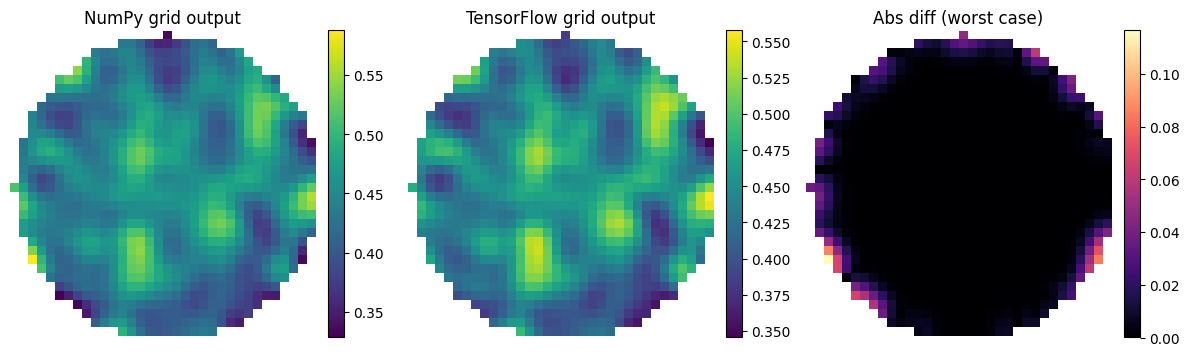

Worst case: mosaic=circle_medium, image=triangle, setting=blur_1p5
max_abs=1.165e-01, mean_abs=4.413e-03, allclose=False


In [11]:
# Visualize the worst-case difference
out_np, out_tf, diff = worst["_outputs"]
valid = out_np != -1
plot_np = out_np.astype(float)
plot_tf = out_tf.astype(float)
plot_diff = np.abs(diff).astype(float)
plot_np[~valid] = np.nan
plot_tf[~valid] = np.nan
plot_diff[~valid] = np.nan

fig, axes = plt.subplots(1, 3, figsize=(12, 4))
im0 = axes[0].imshow(plot_np, cmap="viridis")
axes[0].set_title("NumPy grid output")
axes[0].axis("off")
plt.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04)

im1 = axes[1].imshow(plot_tf, cmap="viridis")
axes[1].set_title("TensorFlow grid output")
axes[1].axis("off")
plt.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)

im2 = axes[2].imshow(plot_diff, cmap="magma")
axes[2].set_title(f"Abs diff (worst case)")
axes[2].axis("off")
plt.colorbar(im2, ax=axes[2], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

print(f"Worst case: mosaic={worst['mosaic']}, image={worst['image']}, setting={worst['setting']}")
print(f"max_abs={worst['max_abs']:.3e}, mean_abs={worst['mean_abs']:.3e}, allclose={worst['allclose']}")


## Interactive explorer (ipywidgets)
Use the dropdowns to inspect any image/mosaic/setting combination.

**Mosaic colors**: each color represents a subtype index value in `mosaic.grid`; `-1` denotes an empty/invalid slot.


In [12]:
import ipywidgets as widgets
from IPython.display import display

if 'results' not in globals():
    raise RuntimeError('Run the batch validation section first so `results` is populated.')

mosaic_dict = {name: m for name, m in mosaics}
image_dict = {name: img for name, img in images}
result_index = {(r['mosaic'], r['image'], r['setting']): r for r in results}

mosaic_opts = sorted({r['mosaic'] for r in results})
image_opts = sorted({r['image'] for r in results})
setting_opts = sorted({r['setting'] for r in results})

def _mask_invalid(arr, valid_mask):
    out = arr.astype(float).copy()
    out[~valid_mask] = np.nan
    return out

def plot_combo(mosaic_name, image_name, setting_name):
    row = result_index[(mosaic_name, image_name, setting_name)]
    out_np, out_tf, diff = row['_outputs']
    mosaic = mosaic_dict[mosaic_name]
    img = image_dict[image_name]
    valid = out_np != -1

    np_masked = _mask_invalid(out_np, valid)
    tf_masked = _mask_invalid(out_tf, valid)
    vmin = np.nanmin([np.nanmin(np_masked), np.nanmin(tf_masked)])
    vmax = np.nanmax([np.nanmax(np_masked), np.nanmax(tf_masked)])

    fig, axes = plt.subplots(1, 5, figsize=(20, 4))
    axes[0].imshow(img[..., :3])
    axes[0].set_title(f'Image: {image_name}')
    axes[0].axis('off')

    axes[1].imshow(mosaic.grid, cmap='tab20', interpolation='nearest')
    axes[1].set_title(f'Mosaic: {mosaic_name} (colors=subtype index)')
    axes[1].axis('off')

    im1 = axes[2].imshow(np_masked, cmap='viridis', vmin=vmin, vmax=vmax)
    axes[2].set_title('NumPy output')
    axes[2].axis('off')
    plt.colorbar(im1, ax=axes[2], fraction=0.046, pad=0.04)

    im2 = axes[3].imshow(tf_masked, cmap='viridis', vmin=vmin, vmax=vmax)
    axes[3].set_title('TensorFlow output')
    axes[3].axis('off')
    plt.colorbar(im2, ax=axes[3], fraction=0.046, pad=0.04)

    im3 = axes[4].imshow(_mask_invalid(np.abs(diff), valid), cmap='magma')
    axes[4].set_title('Abs diff')
    axes[4].axis('off')
    plt.colorbar(im3, ax=axes[4], fraction=0.046, pad=0.04)

    title = (
        'Image={image} | Setting={setting} | max={max_abs:.3e} | mean={mean_abs:.3e}'
    ).format(
        image=image_name,
        setting=setting_name,
        max_abs=row['max_abs'],
        mean_abs=row['mean_abs'],
    )
    fig.suptitle(title, y=1.03)
    plt.tight_layout()
    plt.show()

mosaic_dd = widgets.Dropdown(options=mosaic_opts, value=mosaic_opts[0], description='Mosaic')
image_dd = widgets.Dropdown(options=image_opts, value=image_opts[0], description='Image')
setting_dd = widgets.Dropdown(options=setting_opts, value=setting_opts[0], description='Setting')

ui = widgets.HBox([mosaic_dd, image_dd, setting_dd])
out = widgets.interactive_output(plot_combo, {
    'mosaic_name': mosaic_dd,
    'image_name': image_dd,
    'setting_name': setting_dd,
})

display(ui, out)


Output()

## Differentiability check
This cell verifies gradients flow through the TensorFlow pipeline by backpropagating from a simple scalar loss.


In [13]:
# Use one subtype filter directly to prove gradients flow w.r.t. the input image
subtype = mosaic.subtypes[0]
image_var = tf.Variable(img.astype(np.float64))

with tf.GradientTape() as tape:
    out = bipolar_tf_mod.bipolar_image_filter_tf(
        rgb_image=image_var,
        center_cones=subtype.color_filter_params['center'],
        surround_cones=subtype.color_filter_params['surround'],
        center_sigma=subtype.rf_params['center_sigma'],
        surround_sigma=subtype.rf_params['surround_sigma'],
        alpha_center=subtype.rf_params['alpha_center'],
        alpha_surround=subtype.rf_params['alpha_surround'],
        apply_rectification=subtype.rf_params['apply_rectification'],
        on_k=subtype.rf_params['on_k'],
        on_n=subtype.rf_params['on_n'],
        off_k=subtype.rf_params['off_k'],
        off_n=subtype.rf_params['off_n'],
    )
    loss = tf.reduce_sum(out)

grad = tape.gradient(loss, image_var)

print('Gradient is None:', grad is None)
print('Gradient stats:', float(tf.reduce_min(grad)), float(tf.reduce_max(grad)), float(tf.reduce_mean(tf.abs(grad))))


Gradient is None: False
Gradient stats: -0.25633638697507666 0.15303973098080173 0.031835056388446616
